In [ ]:
!pip install ndlib

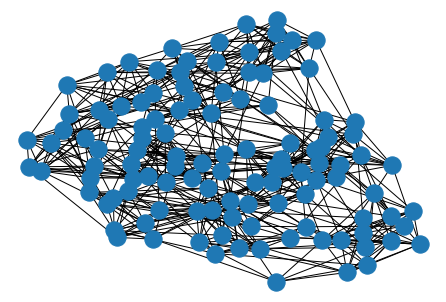

115
[1, 2, 5, 10, 17, 24, 34, 36, 42, 66, 91, 94, 105, 26, 28, 38, 46, 58, 90, 102, 104, 106, 110, 3, 4, 7, 14, 15, 16, 48, 61, 65, 73, 75, 101, 107, 6, 12, 27, 41, 53, 59, 82, 85, 103, 29, 70, 109, 11, 98, 99, 108, 8, 33, 40, 56, 86, 9, 22, 23, 69, 74, 78, 79, 83, 112, 52, 25, 51, 13, 18, 19, 35, 37, 39, 44, 111, 55, 72, 100, 93, 115, 68, 21, 63, 88, 96, 97, 114, 20, 32, 43, 62, 30, 31, 45, 80, 95, 71, 76, 77, 47, 67, 54, 57, 64, 81, 92, 50, 60, 49, 87, 113, 84, 89]
The rumour source in order : 
4 	
63 	
59 	


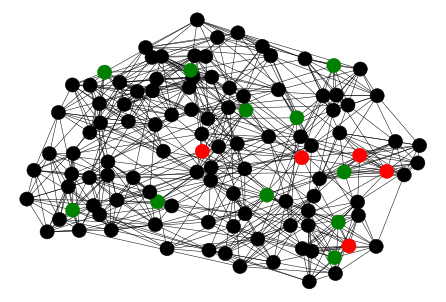

In [ ]:
# Algorithms used for rumor source inference in a graph
# - Pinto algorithm

import networkx as nx
import numpy
# from numpy import matrix, array
# from numpy import linalg
import math
import pandas as pd
import matplotlib.pyplot as plt


def observed_delay(g, O):
    d = numpy.zeros(shape=(len(O) - 1, 1))
    for i in range(len(O) - 1):
        d[i][0] = g.nodes[O[i + 1]]['time'] - g.nodes[O[i]]['time']
    return d


def delay_covariance(T, O, sigma2):
    """
    Computes lambda
    :param T: tree
    :param O: list of observers
    :param sigma2: variance
    :return:
    """
    # TODO stop using all_simple_paths (complexity)
    n = len(O)
    delta = numpy.zeros(shape=(n - 1, n - 1))
    T = T.to_undirected()
    for k in range(n - 1):
        for i in range(n - 1):
            if i == k:
                delta[k][i] = len(list(nx.all_simple_paths(T, O[0], O[k + 1]))[0]) - 1
            else:
                c1 = list(nx.all_simple_paths(T, O[0], O[k + 1]))[0]
                c2 = list(nx.all_simple_paths(T, O[0], O[i + 1]))[0]
                S = [x for x in c1 if x in c2]
                delta[k][i] = len(S) - 1
    delta = delta * (sigma2 ** 2)  # FIXME : square or not ?
    return delta


def deterministic_delay(T, s, O, mi):
    """
    Computes mu_s
    :param T: tree
    :param s: source
    :param O: list of observers
    :param mi: mean
    :return:
    """
    constant = height_node(T, s, O[0])
    mi_s = numpy.zeros(shape=(len(O) - 1, 1))
    for i in range(len(O) - 1):
        mi_s[i][0] = height_node(T, s, O[i + 1]) - constant
    mi_s = mi * mi_s
    return mi_s


def height_node(T, s, node):
    l = list(nx.all_simple_paths(T, s, node))
    if l == []:
        return 0
    else:
        return len(l[0]) - 1


def run(g, O, mi, sigma2, k0):
    """
    Main
    :param g: graph
    :param O: list of observers <<<< ACTIVE observers !
    :param mi: mean
    :param sigma2: variance
    :return:
    """
    # TODO : consider only active observers !
    first_node = O[0]

    # Compute the delay vector d relative to first_node
    d = observed_delay(g, O)

    # Score list of pair (node , score)
    s = {}
    # s=[(O[0],0)]

    # initialise (node , score)
    v = [O[0], 0]
    flag = 0

    # max score
    s_max = 0

    while v[1] >= s_max:
        Tv = {}
        Tv[v[0]] = 0
        for n in g[v[0]]:
            if n not in s.keys():
                tree_bfs = nx.bfs_tree(g, source=first_node)
                mu_s = deterministic_delay(tree_bfs, n, O, mi)
                delta = delay_covariance(tree_bfs, O, sigma2)
                inverse = numpy.linalg.inv(delta)
                score = (numpy.exp(-.5 * numpy.dot(numpy.dot((d - mu_s).T, inverse), (d - mu_s)))) / (
                    numpy.sqrt(abs(numpy.linalg.det(delta))))
                Tv[n] = score[0][0]
        if len(Tv) != 0:
            neighbor_n = [a for a in g[v[0]]]

            if v[0] not in Tv:
                curr_score_node = s[v[0]]
            else:
                curr_score_node = Tv[v[0]]
            curr_node = v[0]

            change = 0

            for a in neighbor_n:
                if a in Tv:
                    neigh_score_a = Tv[a]
                else:
                    continue

                if curr_score_node < neigh_score_a:
                    change = 1
                    curr_node = a

            if change != 0:
                s.update(Tv)
                v = [curr_node, s[curr_node]]
                s_max = v[1]

            else:
                break

        # end of if
    # end of while

    sorted_score = sorted(s.items(), key=lambda kv: kv[1], reverse=True)

    print("The rumour source in order : ")
    for a in range(3):
        print(sorted_score[a][0], "\t")

    return s


def from_pandas_dataframe(df, source, target, edge_attr=None, create_using=None):
    g = nx.Graph()

    # Index of source and target
    src_i = df.columns.get_loc(source)
    tar_i = df.columns.get_loc(target)
    if edge_attr:
        # If all additional columns requested, build up a list of tuples
        # [(name, index),...]
        if edge_attr is True:
            # Create a list of all columns indices, ignore nodes
            edge_i = []
            for i, col in enumerate(df.columns):
                if col is not source and col is not target:
                    edge_i.append((col, i))
        # If a list or tuple of name is requested
        elif isinstance(edge_attr, (list, tuple)):
            edge_i = [(i, df.columns.get_loc(i)) for i in edge_attr]
        # If a string or int is passed
        else:
            edge_i = [(edge_attr, df.columns.get_loc(edge_attr)), ]

        # Iteration on values returns the rows as Numpy arrays
        for row in df.values:
            g.add_edge(row[src_i], row[tar_i], {i: row[j] for i, j in edge_i})

    # If no column names are given, then just return the edges.
    else:
        for row in df.values:
            g.add_edge(row[src_i], row[tar_i])
    return g




####################################################################################
numpy.random.seed(54)  # option for reproducibility---- 51,52,53,54,55,57,58,59
filename = "football"
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/football.csv", delimiter=',')
df = df[["source", "destination"]]
g = from_pandas_dataframe(df, source='source', target='destination')
nx.draw(g)
node_len = len(g.nodes)
plt.savefig(filename+"_PTVA.png")
plt.show()
# ############################################################ Change here
k0 = math.ceil(math.sqrt(len(g)))

# ###################################################################################
O = numpy.random.randint(low=1, high=node_len, size=k0).tolist()
t = numpy.random.uniform(low=0.000000001, high=6, size=k0).tolist()
print(len(g.nodes))
print(g.nodes)
for a in range(0, k0):
    g.nodes[O[a]]['time'] = t[a]
mi = numpy.mean(t)
sigma2 = numpy.var(t)

# #####Running the algorithm:
# run(g, O, mi, sigma2,k0)
score = run(g, O, mi, sigma2, k0)
score = sorted(score.items(), key=lambda kv: kv[1], reverse=True)
score = [list(a)[0] for a in g.nodes(data=True)]

# ################################# Coloring nodes
node_color = []
count = 0
score_list = score[0:5]
for i in range(1, node_len + 1):
    # if the node has the attribute group1
    # elif list(node)[0] in score[:5]:
    if i in O:
        node_color.append('green')
    elif i in score_list:
        node_color.append('red')
    elif 5 == 5:
        count = count + 1
        node_color.append('black')
nx.draw(g, node_size=200, node_color=node_color,
        alpha=1, linewidths=0.5, width=0.5, edge_color='black')
plt.savefig(filename+"_PTVA.png")
plt.show()


import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import random
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep
import matplotlib.pyplot as plt
import pprint

G=nx.Graph()
# gr=pd.read_csv('karate.csv')
#gr=pd.read_csv('dolphin.csv')
gr=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/football.csv")
edge=[(gr['Source'][i],gr['Destination'][i]) for i in range(0,len(gr['Source']))]
G.add_edges_from(edge)
node=max([max(x[0],x[1]) for x in edge])
# compute the best partition
# partition contains color of each node
partition = community_louvain.best_partition(G)

# visualization of clusters
pos = nx.spring_layout(G)
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=200,cmap=cmap, node_color=list(partition.values()),)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

# New Section

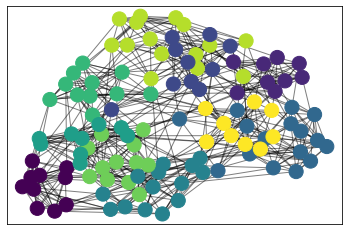

Gateway graph nodes: [1, 2, 34, 36, 66, 28, 58, 102, 3, 4, 15, 73, 75, 12, 27, 59, 5, 6, 109, 91, 98, 7, 8, 56, 86, 41, 74, 83, 9, 10, 42, 23, 65, 11, 61, 13, 14, 18, 46, 111, 16, 69, 93, 115, 17, 39, 68, 82, 19, 20, 37, 45, 21, 22, 76, 33, 47, 24, 48, 79, 112, 25, 26, 67, 85, 88, 54, 107, 29, 114, 30, 43, 92, 31, 51, 110, 32, 80, 50, 35, 95, 38, 60, 81, 96, 40, 55, 52, 64, 44, 71, 63, 62, 49, 97, 99, 53, 113, 87, 90, 57, 89, 72, 106, 77, 105, 70, 84, 104, 78, 108, 94, 101, 100, 103]


 22%|██▏       | 43/200 [00:00<00:00, 429.43it/s]

BCS_value [(65, 0.1600036226258869), (16, 0.13583553278476307), (47, 0.1206075661129222), (99, 0.10804481705739366), (112, 0.09702168400351836), (50, 0.09475754282461264), (64, 0.09127723438389494), (115, 0.08870258241473808), (107, 0.08853438907002044), (10, 0.08430367955286429), (57, 0.08134088909589583), (76, 0.07990477669099007), (108, 0.07584226051855304), (78, 0.07318998085183441), (61, 0.07300884955752156), (56, 0.06747140713139758), (3, 0.065129638254929), (20, 0.06503907260777318), (94, 0.06313719401749161), (59, 0.06268436578171084), (33, 0.058621849609273635), (96, 0.05635770843036734), (15, 0.05634477048077369), (5, 0.05591781814418015), (98, 0.054766340630337425), (39, 0.05201055736686878), (21, 0.05035449981886908), (1, 0.050173368524556027), (40, 0.04983698183511853), (34, 0.0478962893960568), (84, 0.04552864462040078), (42, 0.045489830771619715), (36, 0.0452310717797448), (85, 0.0406639755731511), (80, 0.03909848367230803), (28, 0.03764943331780799), (9, 0.0371448532836

 20%|██        | 41/200 [00:00<00:00, 405.41it/s]

613


 22%|██▏       | 43/200 [00:00<00:00, 425.87it/s]

613


 20%|█▉        | 39/200 [00:00<00:00, 382.84it/s]

613


 21%|██        | 42/200 [00:00<00:00, 416.94it/s]

613


 20%|██        | 41/200 [00:00<00:00, 407.17it/s]

613


 20%|██        | 41/200 [00:00<00:00, 404.63it/s]

613


 20%|█▉        | 39/200 [00:00<00:00, 384.32it/s]

613


 20%|██        | 40/200 [00:00<00:00, 396.17it/s]

613


 20%|██        | 40/200 [00:00<00:00, 392.97it/s]

613


 22%|██▏       | 43/200 [00:00<00:00, 421.38it/s]

613


 22%|██▏       | 43/200 [00:00<00:00, 423.27it/s]

613


 22%|██▏       | 44/200 [00:00<00:00, 437.83it/s]

613


 22%|██▎       | 45/200 [00:00<00:00, 445.12it/s]

613


 19%|█▉        | 38/200 [00:00<00:00, 378.34it/s]

613


 22%|██▎       | 45/200 [00:00<00:00, 446.71it/s]

613


 20%|██        | 40/200 [00:00<00:00, 397.06it/s]

613


 21%|██        | 42/200 [00:00<00:00, 412.80it/s]

613


 19%|█▉        | 38/200 [00:00<00:00, 376.69it/s]

613


 20%|██        | 40/200 [00:00<00:00, 397.52it/s]

613


 22%|██▏       | 44/200 [00:00<00:00, 434.81it/s]

613


 20%|██        | 41/200 [00:00<00:00, 400.12it/s]

613


 20%|█▉        | 39/200 [00:00<00:00, 387.47it/s]

613


 21%|██        | 42/200 [00:00<00:00, 417.77it/s]

613


 21%|██        | 42/200 [00:00<00:00, 418.14it/s]

613


 20%|█▉        | 39/200 [00:00<00:00, 385.46it/s]

613


 20%|██        | 41/200 [00:00<00:00, 408.45it/s]

613


 20%|██        | 41/200 [00:00<00:00, 406.97it/s]

613


 23%|██▎       | 46/200 [00:00<00:00, 452.81it/s]

613


 20%|█▉        | 39/200 [00:00<00:00, 388.86it/s]

613


 22%|██▏       | 43/200 [00:00<00:00, 425.95it/s]

613


 22%|██▏       | 43/200 [00:00<00:00, 427.96it/s]

613


 20%|██        | 41/200 [00:00<00:00, 401.94it/s]

613


 21%|██        | 42/200 [00:00<00:00, 417.19it/s]

613


 21%|██        | 42/200 [00:00<00:00, 417.24it/s]

613


 22%|██▎       | 45/200 [00:00<00:00, 445.90it/s]

613


 22%|██▏       | 43/200 [00:00<00:00, 425.73it/s]

613


 22%|██▏       | 43/200 [00:00<00:00, 424.59it/s]

613


 20%|██        | 41/200 [00:00<00:00, 407.01it/s]

613


 22%|██▎       | 45/200 [00:00<00:00, 449.80it/s]

613


 20%|██        | 40/200 [00:00<00:00, 397.24it/s]

613


 22%|██▏       | 44/200 [00:00<00:00, 435.44it/s]

613


 22%|██▎       | 45/200 [00:00<00:00, 449.61it/s]

613


 21%|██        | 42/200 [00:00<00:00, 415.20it/s]

613


 22%|██▏       | 44/200 [00:00<00:00, 439.49it/s]

613


 20%|██        | 40/200 [00:00<00:00, 393.30it/s]

613


 21%|██        | 42/200 [00:00<00:00, 413.18it/s]

613


 20%|██        | 41/200 [00:00<00:00, 405.36it/s]

613


 20%|██        | 40/200 [00:00<00:00, 395.41it/s]

613


 22%|██▎       | 45/200 [00:00<00:00, 442.04it/s]

613


 20%|██        | 40/200 [00:00<00:00, 397.57it/s]

613


 20%|██        | 40/200 [00:00<00:00, 399.15it/s]

613


 22%|██▎       | 45/200 [00:00<00:00, 443.96it/s]

613


 22%|██▏       | 43/200 [00:00<00:00, 420.81it/s]

613


 22%|██▏       | 43/200 [00:00<00:00, 425.83it/s]

613


 22%|██▎       | 45/200 [00:00<00:00, 442.58it/s]

613


 20%|██        | 40/200 [00:00<00:00, 398.30it/s]

613


 22%|██▏       | 44/200 [00:00<00:00, 434.51it/s]

613


 21%|██        | 42/200 [00:00<00:00, 413.36it/s]

613


 22%|██▎       | 45/200 [00:00<00:00, 444.48it/s]

613


 23%|██▎       | 46/200 [00:00<00:00, 451.99it/s]

613


 22%|██▎       | 45/200 [00:00<00:00, 445.02it/s]

613


 21%|██        | 42/200 [00:00<00:00, 415.41it/s]

613


 21%|██        | 42/200 [00:00<00:00, 415.07it/s]

613


 20%|██        | 41/200 [00:00<00:00, 404.26it/s]

613


 20%|██        | 41/200 [00:00<00:00, 409.72it/s]

613


 20%|██        | 40/200 [00:00<00:00, 395.47it/s]

613


 20%|█▉        | 39/200 [00:00<00:00, 386.98it/s]

613


 20%|██        | 41/200 [00:00<00:00, 405.00it/s]

613


 22%|██▏       | 43/200 [00:00<00:00, 428.49it/s]

613


 22%|██▏       | 43/200 [00:00<00:00, 428.55it/s]

613


 22%|██▏       | 43/200 [00:00<00:00, 422.03it/s]

613


 20%|█▉        | 39/200 [00:00<00:00, 387.31it/s]

613


 20%|██        | 41/200 [00:00<00:00, 405.94it/s]

613


 20%|██        | 41/200 [00:00<00:00, 409.24it/s]

613


 20%|██        | 40/200 [00:00<00:00, 398.91it/s]

613


 20%|█▉        | 39/200 [00:00<00:00, 384.43it/s]

613


 20%|█▉        | 39/200 [00:00<00:00, 386.28it/s]

613


 20%|█▉        | 39/200 [00:00<00:00, 389.39it/s]

613


 20%|██        | 40/200 [00:00<00:00, 394.73it/s]

613


 23%|██▎       | 46/200 [00:00<00:00, 452.52it/s]

613


 23%|██▎       | 46/200 [00:00<00:00, 452.81it/s]

613


 22%|██▏       | 43/200 [00:00<00:00, 427.27it/s]

613


 21%|██        | 42/200 [00:00<00:00, 418.91it/s]

613


 21%|██        | 42/200 [00:00<00:00, 413.40it/s]

613


 21%|██        | 42/200 [00:00<00:00, 414.77it/s]

613


 22%|██▏       | 43/200 [00:00<00:00, 428.37it/s]

613


 20%|██        | 41/200 [00:00<00:00, 408.64it/s]

613


 20%|██        | 40/200 [00:00<00:00, 396.02it/s]

613


 20%|██        | 41/200 [00:00<00:00, 408.96it/s]

613


 21%|██        | 42/200 [00:00<00:00, 418.23it/s]

613


 20%|██        | 40/200 [00:00<00:00, 397.78it/s]

613


 22%|██▏       | 43/200 [00:00<00:00, 426.10it/s]

613


 20%|██        | 41/200 [00:00<00:00, 406.81it/s]

613


 20%|█▉        | 39/200 [00:00<00:00, 382.83it/s]

613


 20%|██        | 41/200 [00:00<00:00, 406.22it/s]

613


 20%|██        | 40/200 [00:00<00:00, 394.85it/s]

613


 20%|██        | 41/200 [00:00<00:00, 402.01it/s]

613


 20%|██        | 41/200 [00:00<00:00, 406.40it/s]

613


 20%|█▉        | 39/200 [00:00<00:00, 388.97it/s]

613


 18%|█▊        | 37/200 [00:00<00:00, 367.66it/s]

613


 22%|██▏       | 43/200 [00:00<00:00, 419.87it/s]

613


 22%|██▏       | 43/200 [00:00<00:00, 426.66it/s]

613


 20%|██        | 41/200 [00:00<00:00, 403.93it/s]

613


 22%|██▏       | 43/200 [00:00<00:00, 429.80it/s]

613


 21%|██        | 42/200 [00:00<00:00, 417.27it/s]

613


 22%|██▏       | 44/200 [00:00<00:00, 433.43it/s]

613


 20%|█▉        | 39/200 [00:00<00:00, 388.96it/s]

613


 20%|██        | 41/200 [00:00<00:00, 405.54it/s]

613


 18%|█▊        | 36/200 [00:00<00:00, 354.92it/s]

613


 21%|██        | 42/200 [00:00<00:00, 413.33it/s]

613


 18%|█▊        | 36/200 [00:00<00:00, 358.10it/s]

613


 21%|██        | 42/200 [00:00<00:00, 417.55it/s]

613


 22%|██▏       | 44/200 [00:00<00:00, 431.72it/s]

613


 20%|██        | 41/200 [00:00<00:00, 406.12it/s]

613


 20%|██        | 41/200 [00:00<00:00, 409.96it/s]

613


 22%|██▏       | 43/200 [00:00<00:00, 424.56it/s]

613


 19%|█▉        | 38/200 [00:00<00:00, 377.87it/s]

613


 20%|█▉        | 39/200 [00:00<00:00, 382.17it/s]

613


 22%|██▏       | 44/200 [00:00<00:00, 432.41it/s]

613


 21%|██        | 42/200 [00:00<00:00, 413.98it/s]

613


 22%|██▏       | 43/200 [00:00<00:00, 424.18it/s]

613


 21%|██        | 42/200 [00:00<00:00, 417.67it/s]

613


 20%|██        | 41/200 [00:00<00:00, 407.63it/s]

613


 22%|██▏       | 44/200 [00:00<00:00, 437.80it/s]

613


 19%|█▉        | 38/200 [00:00<00:00, 376.09it/s]

613


 17%|█▋        | 34/200 [00:00<00:00, 335.31it/s]

613


 20%|██        | 41/200 [00:00<00:00, 406.95it/s]

613


 18%|█▊        | 35/200 [00:00<00:00, 343.33it/s]

613


 21%|██        | 42/200 [00:00<00:00, 413.26it/s]

613


 21%|██        | 42/200 [00:00<00:00, 413.78it/s]

613


 19%|█▉        | 38/200 [00:00<00:00, 376.34it/s]

613


 20%|██        | 41/200 [00:00<00:00, 405.02it/s]

613


 22%|██▎       | 45/200 [00:00<00:00, 447.14it/s]

613


 21%|██        | 42/200 [00:00<00:00, 412.37it/s]

613


 21%|██        | 42/200 [00:00<00:00, 407.39it/s]

613


 20%|█▉        | 39/200 [00:00<00:00, 386.20it/s]

613


 20%|██        | 41/200 [00:00<00:00, 402.93it/s]

613


 20%|██        | 41/200 [00:00<00:00, 409.15it/s]

613


 22%|██▏       | 43/200 [00:00<00:00, 424.19it/s]

613


 20%|██        | 40/200 [00:00<00:00, 392.86it/s]

613


 18%|█▊        | 36/200 [00:00<00:00, 356.01it/s]

613


 20%|██        | 41/200 [00:00<00:00, 403.71it/s]

613


 18%|█▊        | 37/200 [00:00<00:00, 363.84it/s]

613


 18%|█▊        | 37/200 [00:00<00:00, 369.61it/s]

613


 18%|█▊        | 36/200 [00:00<00:00, 356.70it/s]

613


 20%|██        | 40/200 [00:00<00:00, 392.98it/s]

613


 22%|██▏       | 43/200 [00:00<00:00, 423.01it/s]

613


 21%|██        | 42/200 [00:00<00:00, 414.15it/s]

613


 20%|█▉        | 39/200 [00:00<00:00, 385.60it/s]

613


 21%|██        | 42/200 [00:00<00:00, 413.07it/s]

613


 20%|█▉        | 39/200 [00:00<00:00, 382.68it/s]

613


 20%|██        | 41/200 [00:00<00:00, 409.61it/s]

613


 20%|██        | 40/200 [00:00<00:00, 399.94it/s]

613


 20%|█▉        | 39/200 [00:00<00:00, 389.56it/s]

613


 20%|█▉        | 39/200 [00:00<00:00, 388.97it/s]

613


 21%|██        | 42/200 [00:00<00:00, 419.64it/s]

613


 21%|██        | 42/200 [00:00<00:00, 412.57it/s]

613


 21%|██        | 42/200 [00:00<00:00, 419.11it/s]

613


 18%|█▊        | 37/200 [00:00<00:00, 365.58it/s]

613


 20%|█▉        | 39/200 [00:00<00:00, 388.83it/s]

613


 21%|██        | 42/200 [00:00<00:00, 412.67it/s]

613


 20%|██        | 40/200 [00:00<00:00, 392.03it/s]

613


 20%|█▉        | 39/200 [00:00<00:00, 383.16it/s]

613


 20%|██        | 41/200 [00:00<00:00, 399.02it/s]

613


 19%|█▉        | 38/200 [00:00<00:00, 379.37it/s]

613


 20%|██        | 40/200 [00:00<00:00, 398.72it/s]

613


 19%|█▉        | 38/200 [00:00<00:00, 376.19it/s]

613


 20%|█▉        | 39/200 [00:00<00:00, 385.15it/s]

613


 18%|█▊        | 37/200 [00:00<00:00, 367.55it/s]

613


 20%|██        | 41/200 [00:00<00:00, 406.16it/s]

613


 20%|██        | 40/200 [00:00<00:00, 392.34it/s]

613


 20%|██        | 41/200 [00:00<00:00, 402.46it/s]

613


 18%|█▊        | 36/200 [00:00<00:00, 355.22it/s]

613


 20%|██        | 40/200 [00:00<00:00, 399.89it/s]

613


 20%|██        | 41/200 [00:00<00:00, 405.43it/s]

613


 21%|██        | 42/200 [00:00<00:00, 415.35it/s]

613


 19%|█▉        | 38/200 [00:00<00:00, 377.32it/s]

613


 20%|██        | 41/200 [00:00<00:00, 405.81it/s]

613


 20%|██        | 41/200 [00:00<00:00, 397.67it/s]

613


 22%|██▏       | 43/200 [00:00<00:00, 429.37it/s]

613


 18%|█▊        | 37/200 [00:00<00:00, 367.44it/s]

613


 22%|██▏       | 44/200 [00:00<00:00, 437.68it/s]

613


 18%|█▊        | 36/200 [00:00<00:00, 355.74it/s]

613


 20%|██        | 41/200 [00:00<00:00, 403.45it/s]

613


 22%|██▏       | 43/200 [00:00<00:00, 426.33it/s]

613


 19%|█▉        | 38/200 [00:00<00:00, 376.03it/s]

613


 21%|██        | 42/200 [00:00<00:00, 418.92it/s]

613


 21%|██        | 42/200 [00:00<00:00, 416.16it/s]

613


 21%|██        | 42/200 [00:00<00:00, 415.01it/s]

613


 20%|██        | 40/200 [00:00<00:00, 396.54it/s]

613


 20%|██        | 41/200 [00:00<00:00, 406.11it/s]

613


 21%|██        | 42/200 [00:00<00:00, 417.68it/s]

613


 19%|█▉        | 38/200 [00:00<00:00, 376.46it/s]

613


 20%|██        | 41/200 [00:00<00:00, 401.84it/s]

613


 20%|██        | 41/200 [00:00<00:00, 403.70it/s]

613


 20%|██        | 41/200 [00:00<00:00, 409.51it/s]

613


 20%|█▉        | 39/200 [00:00<00:00, 388.39it/s]

613


 19%|█▉        | 38/200 [00:00<00:00, 374.92it/s]

613


 19%|█▉        | 38/200 [00:00<00:00, 374.01it/s]

613


 18%|█▊        | 37/200 [00:00<00:00, 363.48it/s]

613


 20%|██        | 41/200 [00:00<00:00, 402.09it/s]

613


 18%|█▊        | 36/200 [00:00<00:00, 351.00it/s]

613


 21%|██        | 42/200 [00:00<00:00, 416.17it/s]

613


 18%|█▊        | 37/200 [00:00<00:00, 368.72it/s]

613


 20%|██        | 41/200 [00:00<00:00, 406.18it/s]

613


 20%|██        | 40/200 [00:00<00:00, 398.76it/s]

613


 20%|█▉        | 39/200 [00:00<00:00, 382.71it/s]

613


 20%|██        | 40/200 [00:00<00:00, 391.64it/s]

613


 22%|██▏       | 43/200 [00:00<00:00, 425.14it/s]

613


 20%|█▉        | 39/200 [00:00<00:00, 387.27it/s]

613


 22%|██▏       | 43/200 [00:00<00:00, 421.74it/s]

613


 20%|██        | 40/200 [00:00<00:00, 393.15it/s]

613


 20%|█▉        | 39/200 [00:00<00:00, 388.73it/s]

613


 21%|██        | 42/200 [00:00<00:00, 419.28it/s]

613


 20%|██        | 40/200 [00:00<00:00, 392.02it/s]

613


 21%|██        | 42/200 [00:00<00:00, 419.79it/s]

613


 20%|██        | 41/200 [00:00<00:00, 405.18it/s]

613


 20%|██        | 40/200 [00:00<00:00, 394.09it/s]

613


 20%|██        | 40/200 [00:00<00:00, 396.76it/s]

613


 20%|█▉        | 39/200 [00:00<00:00, 387.95it/s]

613


 18%|█▊        | 36/200 [00:00<00:00, 359.46it/s]

613


 20%|██        | 40/200 [00:00<00:00, 398.92it/s]

613


 19%|█▉        | 38/200 [00:00<00:00, 373.30it/s]

613


 20%|██        | 40/200 [00:00<00:00, 399.99it/s]

613


 20%|█▉        | 39/200 [00:00<00:00, 385.12it/s]

613


 20%|██        | 41/200 [00:00<00:00, 403.53it/s]

613


 20%|██        | 40/200 [00:00<00:00, 390.87it/s]

613


 18%|█▊        | 37/200 [00:00<00:00, 362.11it/s]

613


 20%|█▉        | 39/200 [00:00<00:00, 385.77it/s]

613


 21%|██        | 42/200 [00:00<00:00, 412.39it/s]

613


 20%|█▉        | 39/200 [00:00<00:00, 388.92it/s]

613


 20%|█▉        | 39/200 [00:00<00:00, 382.63it/s]

613


 19%|█▉        | 38/200 [00:00<00:00, 376.66it/s]

613


 19%|█▉        | 38/200 [00:00<00:00, 378.06it/s]

613


 22%|██▏       | 43/200 [00:00<00:00, 422.59it/s]

613


 20%|██        | 40/200 [00:00<00:00, 398.29it/s]

613


 21%|██        | 42/200 [00:00<00:00, 416.27it/s]

613


 21%|██        | 42/200 [00:00<00:00, 413.31it/s]

613


 22%|██▏       | 44/200 [00:00<00:00, 431.57it/s]

613


 20%|██        | 41/200 [00:00<00:00, 406.65it/s]

613


 20%|█▉        | 39/200 [00:00<00:00, 387.14it/s]

613


 22%|██▏       | 44/200 [00:00<00:00, 438.90it/s]

613


 20%|██        | 40/200 [00:00<00:00, 392.52it/s]

613


 20%|██        | 41/200 [00:00<00:00, 397.03it/s]

613


 22%|██▏       | 43/200 [00:00<00:00, 422.51it/s]

613


 18%|█▊        | 37/200 [00:00<00:00, 364.64it/s]

613


 21%|██        | 42/200 [00:00<00:00, 416.78it/s]

613


 20%|█▉        | 39/200 [00:00<00:00, 386.92it/s]

613


 20%|██        | 41/200 [00:00<00:00, 408.06it/s]

613


 20%|█▉        | 39/200 [00:00<00:00, 385.31it/s]

613


 20%|██        | 40/200 [00:00<00:00, 398.27it/s]

613


 20%|█▉        | 39/200 [00:00<00:00, 389.16it/s]

613


 19%|█▉        | 38/200 [00:00<00:00, 378.64it/s]

613


 20%|█▉        | 39/200 [00:00<00:00, 384.58it/s]

613


 21%|██        | 42/200 [00:00<00:00, 415.74it/s]

613


 18%|█▊        | 37/200 [00:00<00:00, 367.80it/s]

613


 21%|██        | 42/200 [00:00<00:00, 414.46it/s]

613


 20%|██        | 41/200 [00:00<00:00, 409.68it/s]

613


 19%|█▉        | 38/200 [00:00<00:00, 377.28it/s]

613


 18%|█▊        | 36/200 [00:00<00:00, 359.13it/s]

613


 20%|█▉        | 39/200 [00:00<00:00, 384.14it/s]

613


 18%|█▊        | 37/200 [00:00<00:00, 369.17it/s]

613


 20%|██        | 40/200 [00:00<00:00, 393.72it/s]

613


 19%|█▉        | 38/200 [00:00<00:00, 373.56it/s]

613


 21%|██        | 42/200 [00:00<00:00, 418.59it/s]

613


 20%|██        | 41/200 [00:00<00:00, 406.47it/s]

613


 20%|██        | 40/200 [00:00<00:00, 398.30it/s]

613


 17%|█▋        | 34/200 [00:00<00:00, 337.71it/s]

613


 20%|██        | 40/200 [00:00<00:00, 396.98it/s]

613


 21%|██        | 42/200 [00:00<00:00, 413.04it/s]

613


 20%|██        | 40/200 [00:00<00:00, 393.89it/s]

613


 20%|██        | 41/200 [00:00<00:00, 409.27it/s]

613


 18%|█▊        | 37/200 [00:00<00:00, 366.25it/s]

613


 22%|██▏       | 44/200 [00:00<00:00, 433.74it/s]

613


 19%|█▉        | 38/200 [00:00<00:00, 378.68it/s]

613


 20%|██        | 41/200 [00:00<00:00, 406.33it/s]

613


 18%|█▊        | 36/200 [00:00<00:00, 356.04it/s]

613


 20%|█▉        | 39/200 [00:00<00:00, 384.71it/s]

613


 18%|█▊        | 37/200 [00:00<00:00, 362.71it/s]

613


 19%|█▉        | 38/200 [00:00<00:00, 376.36it/s]

613


 20%|██        | 41/200 [00:00<00:00, 408.26it/s]

613


 19%|█▉        | 38/200 [00:00<00:00, 377.36it/s]

613


 20%|██        | 40/200 [00:00<00:00, 393.47it/s]

613


 19%|█▉        | 38/200 [00:00<00:00, 379.61it/s]

613


 20%|█▉        | 39/200 [00:00<00:00, 384.20it/s]

613


 20%|██        | 41/200 [00:00<00:00, 407.27it/s]

613


 20%|██        | 40/200 [00:00<00:00, 387.25it/s]

613


 20%|██        | 40/200 [00:00<00:00, 397.36it/s]

613


 20%|█▉        | 39/200 [00:00<00:00, 383.39it/s]

613


 20%|██        | 40/200 [00:00<00:00, 395.27it/s]

613


 20%|█▉        | 39/200 [00:00<00:00, 388.46it/s]

613


 20%|██        | 40/200 [00:00<00:00, 394.57it/s]

613


 19%|█▉        | 38/200 [00:00<00:00, 371.68it/s]

613


 19%|█▉        | 38/200 [00:00<00:00, 376.33it/s]

613


 20%|██        | 40/200 [00:00<00:00, 398.68it/s]

613


 17%|█▋        | 34/200 [00:00<00:00, 335.70it/s]

613


 18%|█▊        | 37/200 [00:00<00:00, 365.99it/s]

613


 16%|█▌        | 31/200 [00:00<00:00, 307.01it/s]

613


 18%|█▊        | 37/200 [00:00<00:00, 366.16it/s]

613


 18%|█▊        | 37/200 [00:00<00:00, 369.14it/s]

613


 19%|█▉        | 38/200 [00:00<00:00, 377.12it/s]

613


 20%|██        | 41/200 [00:00<00:00, 404.83it/s]

613


 19%|█▉        | 38/200 [00:00<00:00, 378.56it/s]

613


 18%|█▊        | 37/200 [00:00<00:00, 363.06it/s]

613


 20%|██        | 41/200 [00:00<00:00, 401.55it/s]

613


 19%|█▉        | 38/200 [00:00<00:00, 374.82it/s]

613


 18%|█▊        | 37/200 [00:00<00:00, 367.51it/s]

613


 19%|█▉        | 38/200 [00:00<00:00, 377.93it/s]

613


 19%|█▉        | 38/200 [00:00<00:00, 377.44it/s]

613


 22%|██▎       | 45/200 [00:00<00:00, 444.95it/s]

613


 22%|██▏       | 43/200 [00:00<00:00, 425.27it/s]

613


 20%|█▉        | 39/200 [00:00<00:00, 382.50it/s]

613


 18%|█▊        | 37/200 [00:00<00:00, 368.70it/s]

613


 20%|██        | 40/200 [00:00<00:00, 395.20it/s]

613


 18%|█▊        | 37/200 [00:00<00:00, 364.03it/s]

613


 20%|██        | 40/200 [00:00<00:00, 393.27it/s]

613


 20%|██        | 41/200 [00:00<00:00, 405.48it/s]

613


 21%|██        | 42/200 [00:00<00:00, 415.58it/s]

613


 20%|██        | 41/200 [00:00<00:00, 409.24it/s]

613


 18%|█▊        | 37/200 [00:00<00:00, 365.58it/s]

613


 22%|██▏       | 43/200 [00:00<00:00, 424.74it/s]

613


 20%|██        | 41/200 [00:00<00:00, 408.07it/s]

613


 19%|█▉        | 38/200 [00:00<00:00, 378.09it/s]

613


 19%|█▉        | 38/200 [00:00<00:00, 373.41it/s]

613


 20%|██        | 41/200 [00:00<00:00, 406.65it/s]

613


 18%|█▊        | 37/200 [00:00<00:00, 369.25it/s]

613


 17%|█▋        | 34/200 [00:00<00:00, 330.86it/s]

613


 20%|██        | 40/200 [00:00<00:00, 391.94it/s]

613


 18%|█▊        | 36/200 [00:00<00:00, 354.95it/s]

613


 20%|█▉        | 39/200 [00:00<00:00, 386.16it/s]

613


 19%|█▉        | 38/200 [00:00<00:00, 377.95it/s]

613


 20%|██        | 40/200 [00:00<00:00, 392.71it/s]

613


 20%|█▉        | 39/200 [00:00<00:00, 384.06it/s]

613


 20%|██        | 41/200 [00:00<00:00, 406.17it/s]

613


 22%|██▏       | 43/200 [00:00<00:00, 424.74it/s]

613


 20%|██        | 40/200 [00:00<00:00, 395.58it/s]

613


 19%|█▉        | 38/200 [00:00<00:00, 372.87it/s]

613


 20%|██        | 40/200 [00:00<00:00, 397.31it/s]

613


 21%|██        | 42/200 [00:00<00:00, 417.60it/s]

613


 20%|██        | 40/200 [00:00<00:00, 397.95it/s]

613


 20%|██        | 41/200 [00:00<00:00, 407.57it/s]

613


 20%|██        | 41/200 [00:00<00:00, 402.66it/s]

613


 20%|██        | 40/200 [00:00<00:00, 399.91it/s]

613


 20%|█▉        | 39/200 [00:00<00:00, 382.98it/s]

613


 20%|██        | 41/200 [00:00<00:00, 408.69it/s]

613


 19%|█▉        | 38/200 [00:00<00:00, 373.65it/s]

613


 19%|█▉        | 38/200 [00:00<00:00, 371.95it/s]

613


 19%|█▉        | 38/200 [00:00<00:00, 375.02it/s]

613


 18%|█▊        | 36/200 [00:00<00:00, 352.89it/s]

613


 18%|█▊        | 36/200 [00:00<00:00, 359.19it/s]

613


 20%|██        | 41/200 [00:00<00:00, 399.91it/s]

613


 21%|██        | 42/200 [00:00<00:00, 414.42it/s]

613


 20%|██        | 40/200 [00:00<00:00, 399.06it/s]

613


 20%|█▉        | 39/200 [00:00<00:00, 385.68it/s]

613


 20%|██        | 40/200 [00:00<00:00, 395.92it/s]

613


 20%|██        | 41/200 [00:00<00:00, 401.26it/s]

613


 18%|█▊        | 35/200 [00:00<00:00, 343.50it/s]

613


 18%|█▊        | 37/200 [00:00<00:00, 366.33it/s]

613


 18%|█▊        | 37/200 [00:00<00:00, 364.48it/s]

613


 18%|█▊        | 37/200 [00:00<00:00, 363.05it/s]

613


 20%|██        | 41/200 [00:00<00:00, 405.52it/s]

613


 18%|█▊        | 36/200 [00:00<00:00, 355.19it/s]

613


 20%|██        | 41/200 [00:00<00:00, 409.63it/s]

613


 18%|█▊        | 37/200 [00:00<00:00, 361.57it/s]

613


 18%|█▊        | 37/200 [00:00<00:00, 363.04it/s]

613


 19%|█▉        | 38/200 [00:00<00:00, 368.98it/s]

613


 21%|██        | 42/200 [00:00<00:00, 419.30it/s]

613


 19%|█▉        | 38/200 [00:00<00:00, 377.98it/s]

613


 20%|█▉        | 39/200 [00:00<00:00, 384.34it/s]

613


 20%|██        | 40/200 [00:00<00:00, 392.57it/s]

613


 20%|█▉        | 39/200 [00:00<00:00, 387.14it/s]

613


 18%|█▊        | 35/200 [00:00<00:00, 343.32it/s]

613


 20%|██        | 41/200 [00:00<00:00, 409.43it/s]

613


 21%|██        | 42/200 [00:00<00:00, 418.50it/s]

613


 20%|█▉        | 39/200 [00:00<00:00, 383.55it/s]

613


 20%|██        | 40/200 [00:00<00:00, 399.44it/s]

613


 20%|██        | 41/200 [00:00<00:00, 406.57it/s]

613


 18%|█▊        | 36/200 [00:00<00:00, 358.83it/s]

613


 20%|█▉        | 39/200 [00:00<00:00, 388.30it/s]

613


 18%|█▊        | 36/200 [00:00<00:00, 352.66it/s]

613


 19%|█▉        | 38/200 [00:00<00:00, 379.89it/s]

613


 20%|█▉        | 39/200 [00:00<00:00, 382.67it/s]

613


 21%|██        | 42/200 [00:00<00:00, 415.91it/s]

613


 19%|█▉        | 38/200 [00:00<00:00, 377.40it/s]

613


 18%|█▊        | 37/200 [00:00<00:00, 364.67it/s]

613


 20%|██        | 41/200 [00:00<00:00, 409.49it/s]

613


 20%|██        | 40/200 [00:00<00:00, 395.15it/s]

613


 20%|█▉        | 39/200 [00:00<00:00, 389.93it/s]

613


 18%|█▊        | 37/200 [00:00<00:00, 363.50it/s]

613


 20%|█▉        | 39/200 [00:00<00:00, 384.07it/s]

613


 22%|██▏       | 43/200 [00:00<00:00, 423.06it/s]

613


 19%|█▉        | 38/200 [00:00<00:00, 374.79it/s]

613


 20%|██        | 41/200 [00:00<00:00, 402.63it/s]

613


 16%|█▋        | 33/200 [00:00<00:00, 322.90it/s]

613


 18%|█▊        | 37/200 [00:00<00:00, 363.67it/s]

613


 19%|█▉        | 38/200 [00:00<00:00, 378.42it/s]

613


 20%|█▉        | 39/200 [00:00<00:00, 382.29it/s]

613


 21%|██        | 42/200 [00:00<00:00, 417.64it/s]

613


 16%|█▌        | 32/200 [00:00<00:00, 319.46it/s]

613


 20%|██        | 41/200 [00:00<00:00, 409.46it/s]

613


 18%|█▊        | 35/200 [00:00<00:00, 345.28it/s]

613


 20%|██        | 41/200 [00:00<00:00, 403.26it/s]

613


 18%|█▊        | 37/200 [00:00<00:00, 366.48it/s]

613


 20%|██        | 40/200 [00:00<00:00, 395.39it/s]

613


 21%|██        | 42/200 [00:00<00:00, 419.04it/s]

613


 21%|██        | 42/200 [00:00<00:00, 413.32it/s]

613


 19%|█▉        | 38/200 [00:00<00:00, 372.50it/s]

613


 19%|█▉        | 38/200 [00:00<00:00, 379.74it/s]

613


 20%|██        | 40/200 [00:00<00:00, 398.07it/s]

613


 20%|█▉        | 39/200 [00:00<00:00, 389.83it/s]

613


 19%|█▉        | 38/200 [00:00<00:00, 376.39it/s]

613


 20%|██        | 41/200 [00:00<00:00, 402.74it/s]

613


 20%|██        | 40/200 [00:00<00:00, 398.57it/s]

613


 21%|██        | 42/200 [00:00<00:00, 415.42it/s]

613


 18%|█▊        | 36/200 [00:00<00:00, 358.95it/s]

613


 18%|█▊        | 35/200 [00:00<00:00, 345.42it/s]

613


 20%|█▉        | 39/200 [00:00<00:00, 385.17it/s]

613


 18%|█▊        | 36/200 [00:00<00:00, 350.73it/s]

613


 20%|██        | 41/200 [00:00<00:00, 403.75it/s]

613


 19%|█▉        | 38/200 [00:00<00:00, 377.62it/s]

613


 21%|██        | 42/200 [00:00<00:00, 412.14it/s]

613


 22%|██▏       | 43/200 [00:00<00:00, 429.37it/s]

613


 20%|█▉        | 39/200 [00:00<00:00, 386.43it/s]

613


 20%|█▉        | 39/200 [00:00<00:00, 382.61it/s]

613


 20%|██        | 40/200 [00:00<00:00, 398.65it/s]

613


 20%|██        | 40/200 [00:00<00:00, 397.43it/s]

613


 20%|██        | 41/200 [00:00<00:00, 404.33it/s]

613


 18%|█▊        | 35/200 [00:00<00:00, 343.63it/s]

613


 18%|█▊        | 37/200 [00:00<00:00, 362.77it/s]

613


 20%|██        | 40/200 [00:00<00:00, 396.11it/s]

613


 20%|█▉        | 39/200 [00:00<00:00, 382.87it/s]

613


 20%|██        | 41/200 [00:00<00:00, 402.64it/s]

613


 20%|██        | 41/200 [00:00<00:00, 409.16it/s]

613


 21%|██        | 42/200 [00:00<00:00, 413.83it/s]

613


 20%|██        | 40/200 [00:00<00:00, 393.27it/s]

613


 16%|█▋        | 33/200 [00:00<00:00, 329.23it/s]

613


 18%|█▊        | 37/200 [00:00<00:00, 369.86it/s]

613


 19%|█▉        | 38/200 [00:00<00:00, 378.57it/s]

613


 20%|██        | 41/200 [00:00<00:00, 406.51it/s]

613


 18%|█▊        | 37/200 [00:00<00:00, 368.29it/s]

613


 18%|█▊        | 37/200 [00:00<00:00, 369.96it/s]

613


 18%|█▊        | 37/200 [00:00<00:00, 367.44it/s]

613


 20%|██        | 40/200 [00:00<00:00, 398.29it/s]

613


 17%|█▋        | 34/200 [00:00<00:00, 339.82it/s]

613


 19%|█▉        | 38/200 [00:00<00:00, 369.08it/s]

613


 18%|█▊        | 37/200 [00:00<00:00, 368.82it/s]

613


 20%|██        | 40/200 [00:00<00:00, 392.82it/s]

613


 19%|█▉        | 38/200 [00:00<00:00, 379.82it/s]

613


 20%|██        | 40/200 [00:00<00:00, 397.78it/s]

613


 18%|█▊        | 37/200 [00:00<00:00, 362.90it/s]

613


 18%|█▊        | 37/200 [00:00<00:00, 366.54it/s]

613


 18%|█▊        | 37/200 [00:00<00:00, 364.43it/s]

613


 20%|█▉        | 39/200 [00:00<00:00, 382.87it/s]

613


 20%|██        | 40/200 [00:00<00:00, 392.50it/s]

613


 18%|█▊        | 36/200 [00:00<00:00, 353.86it/s]

613


 16%|█▋        | 33/200 [00:00<00:00, 323.15it/s]

613


 20%|██        | 40/200 [00:00<00:00, 391.68it/s]

613


 20%|██        | 41/200 [00:00<00:00, 404.28it/s]

613


 20%|██        | 41/200 [00:00<00:00, 397.18it/s]

613


 19%|█▉        | 38/200 [00:00<00:00, 379.71it/s]

613


 18%|█▊        | 36/200 [00:00<00:00, 359.35it/s]

613


 18%|█▊        | 37/200 [00:00<00:00, 364.01it/s]

613


 20%|█▉        | 39/200 [00:00<00:00, 385.64it/s]

613


 20%|██        | 41/200 [00:00<00:00, 406.02it/s]

613


 19%|█▉        | 38/200 [00:00<00:00, 372.60it/s]

613


 19%|█▉        | 38/200 [00:00<00:00, 376.68it/s]

613


 19%|█▉        | 38/200 [00:00<00:00, 378.47it/s]

613


 20%|█▉        | 39/200 [00:00<00:00, 389.73it/s]

613


 19%|█▉        | 38/200 [00:00<00:00, 379.86it/s]

613


 18%|█▊        | 37/200 [00:00<00:00, 368.51it/s]

613


 20%|█▉        | 39/200 [00:00<00:00, 389.70it/s]

613


 18%|█▊        | 35/200 [00:00<00:00, 348.51it/s]

613


 19%|█▉        | 38/200 [00:00<00:00, 376.09it/s]

613


 18%|█▊        | 37/200 [00:00<00:00, 369.60it/s]

613


 20%|██        | 41/200 [00:00<00:00, 407.04it/s]

613


 20%|██        | 41/200 [00:00<00:00, 406.39it/s]

613


 20%|██        | 40/200 [00:00<00:00, 395.65it/s]

613


 18%|█▊        | 35/200 [00:00<00:00, 348.99it/s]

613


 18%|█▊        | 37/200 [00:00<00:00, 365.91it/s]

613


 20%|██        | 41/200 [00:00<00:00, 407.93it/s]

613


 17%|█▋        | 34/200 [00:00<00:00, 338.09it/s]

613


 20%|██        | 40/200 [00:00<00:00, 396.73it/s]

613


 18%|█▊        | 35/200 [00:00<00:00, 347.65it/s]

613


 19%|█▉        | 38/200 [00:00<00:00, 376.31it/s]

613


 20%|█▉        | 39/200 [00:00<00:00, 385.63it/s]

613


 18%|█▊        | 37/200 [00:00<00:00, 364.96it/s]

613


 17%|█▋        | 34/200 [00:00<00:00, 333.24it/s]

613


 19%|█▉        | 38/200 [00:00<00:00, 373.61it/s]

613


 18%|█▊        | 37/200 [00:00<00:00, 362.88it/s]

613


 20%|██        | 41/200 [00:00<00:00, 402.78it/s]

613


 20%|█▉        | 39/200 [00:00<00:00, 384.31it/s]

613


 18%|█▊        | 35/200 [00:00<00:00, 349.84it/s]

613


 18%|█▊        | 36/200 [00:00<00:00, 358.66it/s]

613


 16%|█▋        | 33/200 [00:00<00:00, 326.26it/s]

613


 19%|█▉        | 38/200 [00:00<00:00, 377.43it/s]

613


 19%|█▉        | 38/200 [00:00<00:00, 377.72it/s]

613


 19%|█▉        | 38/200 [00:00<00:00, 379.38it/s]

613


 18%|█▊        | 36/200 [00:00<00:00, 357.63it/s]

613


 18%|█▊        | 36/200 [00:00<00:00, 355.58it/s]

613


100%|██████████| 200/200 [00:00<00:00, 409.10it/s]


gateNodesList 115
792


100%|██████████| 200/200 [00:00<00:00, 817.97it/s]


[[0.1353352832366127, 0.1353352832366127, 0.1353352832366127, 0.1353352832366127, 0.1353352832366127, 0.1353352832366127, 0.1353352832366127, 0.1353352832366127, 0.1353352832366127, 0.1353352832366127, 0.1353352832366127, 0.1353352832366127, 0.1353352832366127, 0.1353352832366127, 0.1353352832366127, 0.1353352832366127, 0.1353352832366127, 0.1353352832366127, 0.1353352832366127, 0.1353352832366127], [0.1353352832366127, 0.1353352832366127, 0.1353352832366127, 4.266607746861169e-06, 0.1353352832366127, 0.1353352832366127, 0.1353352832366127, 0.1353352832366127, 2.6286716910436938e-08, 0.1353352832366127, 0.1353352832366127, 0.1353352832366127, 0.1353352832366127, 0.1353352832366127, 0.1353352832366127, 0.1353352832366127, 0.1353352832366127, 0.1353352832366127, 0.1353352832366127, 0.1353352832366127], [0.1353352832366127, 0.1353352832366127, 0.1353352832366127, 0.1353352832366127, 0.1353352832366127, 0.1353352832366127, 0.1353352832366127, 0.1353352832366127, 0.1353352832366127, 0.13533

/usr/local/lib/python3.7/dist-packages/ndlib/models/DiffusionModel.py:170: UserWarning: The fraction_infected value is too low given the number of nodes of the selected graph: a single node will be set as infected
  "The fraction_infected value is too low given the number of nodes of the selected graph: a "
100%|██████████| 200/200 [00:00<00:00, 2857.15it/s]


time_of_diffusion_cg {1: 9, 2: -1, 3: -1, 4: -1, 5: 5, 6: -1, 7: -1, 8: -1, 9: -1, 10: 4, 11: -1, 12: 26, 13: -1, 14: -1, 15: -1, 16: -1, 17: 9, 18: -1, 19: -1, 20: -1, 21: -1, 22: -1, 23: -1, 24: 16, 25: 26, 26: -1, 27: -1, 28: -1, 29: 24, 30: -1, 31: -1, 32: -1, 33: -1, 34: -1, 35: -1, 36: -1, 37: -1, 38: -1, 39: -1, 40: -1, 41: -1, 42: 0, 43: -1, 44: -1, 45: -1, 46: -1, 47: -1, 48: -1, 49: -1, 50: -1, 51: 34, 52: -1, 53: -1, 54: -1, 55: -1, 56: -1, 57: -1, 58: -1, 59: -1, 60: -1, 61: -1, 62: -1, 63: -1, 64: -1, 65: -1, 66: -1, 67: -1, 68: -1, 69: -1, 70: 28, 71: -1, 72: -1, 73: -1, 74: -1, 75: -1, 76: -1, 77: -1, 78: -1, 79: -1, 80: -1, 81: -1, 82: -1, 83: -1, 84: -1, 85: -1, 86: -1, 87: -1, 88: -1, 89: -1, 90: -1, 91: 10, 92: -1, 93: -1, 94: 12, 95: -1, 96: -1, 97: -1, 98: -1, 99: -1, 100: -1, 101: -1, 102: -1, 103: -1, 105: 7}
sensor_nodes_cg [5, 94, 1]
[7, 4]


100%|██████████| 200/200 [00:00<00:00, 3778.01it/s]


toTakeArgmax_cg [[0.1353352832366127, 0.1353352832366127, 0.1353352832366127, 0.1353352832366127, 0.1353352832366127, 0.1353352832366127, 0.1353352832366127, 0.1353352832366127, 6.249589857207967e-10, 0.1353352832366127, 0.1353352832366127, 1.0984370709627581e-06, 0.1353352832366127, 0.1353352832366127, 6.249589857207967e-10, 0.0003797917288483845, 0.1353352832366127, 0.1353352832366127, 0.1353352832366127, 0.1353352832366127], [0.1353352832366127, 0.1353352832366127, 0.1353352832366127, 0.1353352832366127, 6.249589857207967e-10, 0.1353352832366127, 0.1353352832366127, 3.383329215983314e-06, 0.1353352832366127, 0.1353352832366127, 0.1353352832366127, 0.1353352832366127, 0.1353352832366127, 2.5124409501988335e-07, 0.1353352832366127, 0.1353352832366127, 0.1353352832366127, 0.1353352832366127, 0.1353352832366127, 0.1353352832366127], [7.176014940959088e-06, 6.249589857207967e-10, 3.383329215983314e-06, 0.1353352832366127, 6.249589857207967e-10, 6.227054973474988e-08, 0.1353352832366127, 

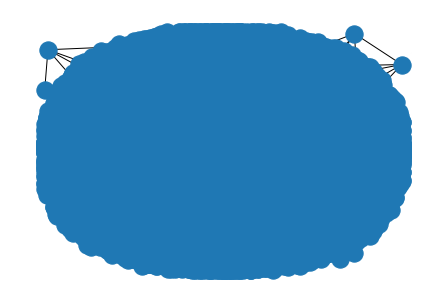

In [ ]:
import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import random
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep
import matplotlib.pyplot as plt
import pprint

G=nx.Graph()
# gr=pd.read_csv('karate.csv')
#gr=pd.read_csv('dolphin.csv')
gr=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/football.csv")
edge=[(gr['source'][i],gr['destination'][i]) for i in range(0,len(gr['source']))]
G.add_edges_from(edge)
node=max([max(x[0],x[1]) for x in edge])
# compute the best partition
# partition contains color of each node
partition = community_louvain.best_partition(G)

# visualization of clusters
pos = nx.spring_layout(G)
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=200,cmap=cmap, node_color=list(partition.values()),)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

# Generating gateEdges
# gateEdges contains edges--> [(a,b),(b,c)]
gateEdges=[]
for x in edge:
    if(partition[x[0]]!=partition[x[1]]):
        gateEdges.append(x)

# Generating gate nodes 
gateNodesDict={}

for tup in gateEdges:
    gateNodesDict[tup[0]]=1
    gateNodesDict[tup[1]]=1

gateNodesList=list(gateNodesDict.keys())

print("Gateway graph nodes:",gateNodesList)
for x in gateNodesList:
    for y in gateNodesList:
        if(x==y or ((x,y) in gateEdges) or ((y,x) in gateEdges)):
            continue
        else:
            if(partition[x]==partition[y]):
                if((x,y) in edge or (y,x) in edge):
                    gateEdges.append((x,y))

gatewayGraph=nx.Graph()
gatewayGraph.add_edges_from(gateEdges)


# Gate graph
# This is the gate way graph
# gate
tot_g=[]
tot_graphs=[]
for i in range(0,500):
    g = G
    gatew = gatewayGraph
    attr = {(u, v): {"weight": round(random.uniform(0,1),2)} for (u, v) in G.edges()}
    nx.set_edge_attributes(g, attr)
    tot_g.append(g.subgraph(gatew))
    tot_graphs.append(g)
# for k in range(0,500):
#     print(len(tot_g[k]))
#     tot_g[k].add_nodes_from(gateNodesList)
#     print(len(tot_g[k]))
#     for i in range(0,len(gateEdges)):
#         tot_g[k].add_edge(gateEdges[i][0],gateEdges[i][1],weight=round(random.uniform(0,1),2))
#     break

#BCS Score
def BCS(gg,nodes,nodeList):
    BCS_={}
    for node in nodeList:
        BCS_[node]=0
    for i in gg:
        x=(nx.betweenness_centrality(i,weight='weight'))
        for j in x:
            BCS_[j]+=(1/500)*x[j]
    return BCS_
BCS_value=BCS(tot_g,len(gateNodesList),gateNodesList)
BCS_value=(sorted(BCS_value.items(), key=lambda x: x[1],reverse=True))
print("BCS_value",BCS_value)

# Model selection - diffusion time
model = ep.SIModel(G)

# Model Configuration
cfg = mc.Configuration()
cfg.add_model_parameter('beta', 0.03)
cfg.add_model_parameter("fraction_infected", 1/max([max(x[0],x[1]) for x in edge]))
model.set_initial_status(cfg)

# Simulation execution
iterations = model.iteration_bunch(200)

#Mapping diffusion_time_to_each_node
time_of_diffusion={}
for i in range(1,node+1):
    time_of_diffusion[i]=-1
for i in iterations:
    for j in i['status']:
        if(i['status'][j]==1):
            time_of_diffusion[j]=i['iteration']


print("time_of_diffusion",time_of_diffusion)
sensor_nodes=[BCS_value[i][0] for i in range(0,3)]
print("sensor_nodes",sensor_nodes)
print("gateNodesList",gateNodesList)
print("len of gateNodesList",len(gateNodesList))
print("len of gateEdges",len(gateEdges))

delta_t=[]
min_v=min([time_of_diffusion[i] for i in sensor_nodes])
min_n=-1
for i in sensor_nodes:
    if(time_of_diffusion[i]==min_v):
        min_n=i
        break
delta_t=[abs(time_of_diffusion[i]-min_v) for i in sensor_nodes if(i!=min_n)]
print("delta_t",delta_t)

timeOfDiffusions=[]
for i in tot_g:
    print(len(i.edges()))
    # Model selection - diffusion time
    model = ep.SIModel(i)

    # Model Configuration
    cfg = mc.Configuration()
    cfg.add_model_parameter('beta', 0.03)
    cfg.add_model_parameter("fraction_infected", 1/max([max(x[0],x[1]) for x in edge]))
    model.set_initial_status(cfg)

    # Simulation execution
    iterations = model.iteration_bunch(200)

    #Mapping diffusion_time_to_each_node
    time_of_diffusion={}
    for i in range(1,node+1):
        time_of_diffusion[i]=-1
    for i in iterations:
        for j in i['status']:
            if(i['status'][j]==1):
                time_of_diffusion[j]=i['iteration']
    timeOfDiffusions.append(len(time_of_diffusion))

#for i in timeOfDiffusions:
    #print("len of nodes infected ",i)
print("gateNodesList",len(gateNodesList))

g__ = nx.Graph()
g__.add_edges_from(gateEdges)
print(len(gateEdges))
allDiffusionTime = []
mcaps=[tot_g[i] for i in random.sample(range(0, 500), 20)]
toTakeArgmax=[]
for node in gateNodesList:
#     print(node)
    bfs_tree = nx.bfs_tree(g__, source = node)
    nx.draw(bfs_tree)
    vecOfArgmax=[]
    for mcap in mcaps:
        model = ep.SIModel(bfs_tree)
        # Model Configuration
        cfg = mc.Configuration()
        cfg.add_model_parameter('beta', 0.03)
        cfg.add_model_parameter("fraction_infected", 1/max([max(x[0],x[1]) for x in bfs_tree.edges()]))
        model.set_initial_status(cfg)

        # Simulation execution
        iterations = model.iteration_bunch(200)

        #Mapping diffusion_time_to_each_node
        
        time_of_diffusion={}
        for i in range(1,node+1):
            time_of_diffusion[i]=-1
        for i in iterations:
            for j in i['status']:
                if(i['status'][j]==1):
                    time_of_diffusion[j]=i['iteration']
        allDiffusionTime.append(time_of_diffusion)
        
        for node in gateNodesList:
            if node not in time_of_diffusion.keys(): 
                time_of_diffusion[node]=-1
        
        min_v=min([time_of_diffusion[i] for i in sensor_nodes])
        min_n=-1
        for i in sensor_nodes:
            if(time_of_diffusion[i]==min_v):
                min_n=i
                break
        mu=[abs(time_of_diffusion[i]+min_v)/2 for i in sensor_nodes if(i!=min_n)]
#         print(len(delta_t),len(mu))
        
        arrivals=[]
        
        for sensor in sensor_nodes:
            if(time_of_diffusion[sensor]==-1):
                arrivals.append(200)
            else:
                arrivals.append(time_of_diffusion[sensor])
                
#         print("arrivals",arrivals)
                
        new_delta_ts = []
            
        for i in range(0,len(arrivals)):
            new_delta_t=[]
            for j in range(0,len(arrivals)):
                if(i!=j):
                    new_delta_t.append(abs(arrivals[j]-arrivals[i]))
            new_delta_ts.append(new_delta_t)
#             print("new_delta_ts",new_delta_ts)
#         print(new_delta_ts)
            
        lambd = []
        for i in range(0,len(new_delta_ts)-1):
#             print("---> ",len(new_delta_ts[i]),len(new_delta_ts[i+1]))
            val = np.correlate(new_delta_ts[i],new_delta_ts[i+1],"same")
            for i in range(0,len(val)):
                if (val[i]==0):
                    val[i]=1
            lambd.append(val)
#         print("lambd",lambd)
#         print("delta_t",delta_t,"mu",mu)    
        sub = np.subtract(delta_t,mu)
#         print("sub",sub)
        lambd[0][1]=0
        powerOfe = np.dot(np.dot((sub), np.linalg.inv(lambd) ),np.transpose(sub))
#         print("powerOfe",powerOfe)
        powerOfe=abs(powerOfe)
        fun = (1/np.linalg.det(lambd))*np.exp(-(1/2)*powerOfe)
        vecOfArgmax.append(fun)
    toTakeArgmax.append(vecOfArgmax)
print(toTakeArgmax)
#     print(node)
# nx.draw(nx.bfs_tree(g, source = 5))
#     print(time_of_diffusion)



print("allDiffusionTime",allDiffusionTime)
nx.draw(nx.bfs_tree(g, source = 5))


print(len(toTakeArgmax[0]),len(toTakeArgmax))

finArg = np.argmax(toTakeArgmax,axis=1)

id=-1
mx=-1
for i in range(0,len(finArg)):
    if(toTakeArgmax[i][finArg[i]]>mx):
        mx=toTakeArgmax[i][finArg[i]]
        id=i
clusterNode=gateNodesList[id]

print("clusterNode",clusterNode)

partition[clusterNode]
color=partition[clusterNode]
print(partition[clusterNode])


print("partition",partition[52])

candidateCluster=[]
for e in G.edges():
    if(partition[e[0]]==color and partition[e[1]]==color):
        candidateCluster.append(e)
candidateGraph = nx.Graph()
candidateGraph.add_edges_from(candidateCluster)
nx.draw(candidateGraph)

myset=set([])
for e in candidateCluster:
    myset.add(e[0])
    myset.add(e[1])
print("myset",myset)
my=[]
for ele in myset:
    my.append(ele)
print("list",my)


cG = G.subgraph(my)
nx.draw(cG)

tot_cg_set=set([])
for i in range(0,500):
    tot_cg_set.add(tot_g[i].subgraph(my))
print(len(tot_cg_set))
tot_cg=[]
for g in tot_cg_set:
    tot_cg.append(g)
# print(len(tot_cg))
nx.draw(tot_g[7].subgraph(my))



print(len(cG.edges()))
nodes_in_cg=[]
nodes_in_cg_set=set([])
for ee in cG.edges():
    nodes_in_cg_set.add(ee[0])
    nodes_in_cg_set.add(ee[1])
for ele in nodes_in_cg_set:
    nodes_in_cg.append(ele)
print("nodes_in_cg",nodes_in_cg)
print(len(tot_cg[0]))
BCS_value_cg=BCS(tot_cg, len(tot_cg)+2, nodes_in_cg) 
BCS_value_cg=(sorted(BCS_value_cg.items(), key=lambda x: x[1],reverse=True))


# Model selection - diffusion time
model = ep.SIModel(cG)

# Model Configuration
cfg = mc.Configuration()
cfg.add_model_parameter('beta', 0.03)
cfg.add_model_parameter("fraction_infected", 1/max([max(x[0],x[1]) for x in cG.edges()]))
model.set_initial_status(cfg)

# Simulation execution
iterations = model.iteration_bunch(200)

#Mapping diffusion_time_to_each_node
time_of_diffusion_cg={}
for i in range(1,node+1):
    time_of_diffusion_cg[i]=-1
for i in iterations:
    for j in i['status']:
        if(i['status'][j]==1):
            time_of_diffusion_cg[j]=i['iteration']

print("time_of_diffusion_cg",time_of_diffusion_cg)
sensor_nodes_cg=[BCS_value_cg[i][0] for i in range(0,3)]
print("sensor_nodes_cg",sensor_nodes_cg)


delta_t_cg=[]
min_v_cg=min([time_of_diffusion_cg[i] for i in sensor_nodes_cg])
min_n_cg=-1
for i in sensor_nodes_cg:
    if(time_of_diffusion_cg[i]==min_v_cg):
        min_n_cg=i
        break
delta_t_cg=[abs(time_of_diffusion_cg[i]-min_v_cg) for i in sensor_nodes_cg if(i!=min_n_cg)]
print(delta_t_cg)




g___cg = nx.Graph()
g___cg.add_edges_from(cG.edges())
# allDiffusionTime = []
mcaps_cg=[tot_cg[i] for i in random.sample(range(0, 500), 20)]
toTakeArgmax_cg=[]
for node in nodes_in_cg:
#     print(node)
    bfs_tree = nx.bfs_tree(g___cg, source = node)
    nx.draw(bfs_tree)
    vecOfArgmax_cg=[]
    for mcap_cg in mcaps_cg:
        model = ep.SIModel(bfs_tree)
        # Model Configuration
        cfg = mc.Configuration()
        cfg.add_model_parameter('beta', 0.03)
        cfg.add_model_parameter("fraction_infected", 1/max([max(x[0],x[1]) for x in bfs_tree.edges()]))
        model.set_initial_status(cfg)

        # Simulation execution
        iterations = model.iteration_bunch(200)

        #Mapping diffusion_time_to_each_node
        
        time_of_diffusion_cg={}
        for i in range(1,node+1):
            time_of_diffusion_cg[i]=-1
        for i in iterations:
            for j in i['status']:
                if(i['status'][j]==1):
                    time_of_diffusion_cg[j]=i['iteration']
        
        for node in nodes_in_cg:
            if node not in time_of_diffusion_cg.keys(): 
                time_of_diffusion_cg[node]=-1
        
        min_v_cg=min([time_of_diffusion_cg[i] for i in sensor_nodes_cg])
        min_n_cg=-1
        for i in sensor_nodes_cg:
            if(time_of_diffusion_cg[i]==min_v_cg):
                min_n_cg=i
                break
        mu_cg=[abs(time_of_diffusion_cg[i]+min_v_cg)/2 for i in sensor_nodes_cg if(i!=min_n_cg)]
#         print(len(delta_t_cg),len(mu_cg))
        
        arrivals_cg=[]
        
        for sensor in sensor_nodes_cg:
            if(time_of_diffusion_cg[sensor]==-1):
                arrivals_cg.append(200)
            else:
                arrivals_cg.append(time_of_diffusion_cg[sensor])
                
#         print("arrivals_cg",arrivals_cg)
                
        new_delta_ts_cg = []
            
        for i in range(0,len(arrivals_cg)):
            new_delta_t_cg=[]
            for j in range(0,len(arrivals_cg)):
                if(i!=j):
                    new_delta_t_cg.append(abs(arrivals_cg[j]-arrivals_cg[i]))
            new_delta_ts_cg.append(new_delta_t_cg)
#             print("new_delta_ts_cg",new_delta_ts_cg)
#         print(new_delta_ts_cg)
            
        lambd_cg = []
        for i in range(0,len(new_delta_ts_cg)-1):
#             print("---> ",len(new_delta_ts_cg[i]),len(new_delta_ts_cg[i+1]))
            val_cg = np.correlate(new_delta_ts_cg[i],new_delta_ts_cg[i+1],"same")
            for i in range(0,len(val_cg)):
                if (val_cg[i]==0):
                    val_cg[i]=1
            lambd_cg.append(val_cg)
#         print("lambd_cg",lambd_cg)
#         print("delta_t_cg",delta_t_cg,"mu_cg",mu_cg)    
        sub_cg = np.subtract(delta_t,mu_cg)
#         print("sub_cg",sub_cg)
        lambd_cg[0][1]=0
        powerOfe_cg = np.dot(np.dot((sub_cg), np.linalg.inv(lambd_cg) ),np.transpose(sub_cg))
#         print("powerOfe_cg",powerOfe_cg)
        powerOfe_cg=abs(powerOfe_cg)
        fun_cg = (1/np.linalg.det(lambd_cg))*np.exp(-(1/2)*powerOfe_cg)
        vecOfArgmax_cg.append(fun_cg)
    toTakeArgmax_cg.append(vecOfArgmax_cg)
print("toTakeArgmax_cg",toTakeArgmax_cg)
#     print(node)
# nx.draw(nx.bfs_tree(g, source = 5))
#     print(time_of_diffusion)



print(len(toTakeArgmax_cg[0]),len(toTakeArgmax_cg))

finArg_cg = np.argmax(toTakeArgmax_cg,axis=1)

id_cg=-1
mx_cg=-1
for i in range(0,len(finArg_cg)):
    if(toTakeArgmax_cg[i][finArg_cg[i]]>mx):
        mx_cg=toTakeArgmax_cg[i][finArg_cg[i]]
        id_cg=i
source_node=nodes_in_cg[id_cg]
print("source_node",source_node)

print("partition_source node",partition[source_node])
print("partition",partition[16])


nx.draw(G.subgraph(gatew))

